In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Dataset folder
dataset_dir = '../PlantVillage'

# Parameter global
Image_Size = 256
Batch_Size = 32
Epochs = 40

# Load dataset
dataset = image_dataset_from_directory(
    dataset_dir,
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    shuffle=True
)

class_name = dataset.class_names


Found 2152 files belonging to 3 classes.


In [3]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)

# Optimisasi pipeline
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [4]:
# ANN model: input -> 2 hidden layers -> output
model_ann = models.Sequential([
    layers.Flatten(input_shape=(Image_Size, Image_Size, 3)),  # Input layer
    layers.Dense(128, activation='relu'),                     # Hidden layer 1
    layers.Dense(64, activation='relu'),                      # Hidden layer 2
    layers.Dense(len(class_name), activation='softmax')       # Output layer
])


C:\Users\BSOK AKU\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
model_ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,174,403 (96.03 MB)

 Trainable params: 25,174,403 (96.03 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model_ann.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [7]:
history = model_ann.fit(
    train_ds,
    epochs=Epochs,
    validation_data=val_ds
)


Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.4573 - loss: 8141.2251 - val_accuracy: 0.8125 - val_loss: 383.2646
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.7436 - loss: 867.6166 - val_accuracy: 0.6979 - val_loss: 745.1955
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.7501 - loss: 592.9453 - val_accuracy: 0.8281 - val_loss: 512.3832
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.7401 - loss: 741.9620 - val_accuracy: 0.4062 - val_loss: 1496.4430
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.6836 - loss: 964.4589 - val_accuracy: 0.8698 - val_loss: 259.6873
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.7708 - loss: 470.7149 - val_accuracy: 0.6354 - val_loss: 483.1713
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.7553 - loss: 496.5174 - val_accuracy: 0.6250 - val_loss: 665.2151
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.7593 -

In [12]:
scores = model_ann.evaluate(test_ds)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9123 - loss: 26.5863
Test Loss: 16.4553
Test Accuracy: 0.9297


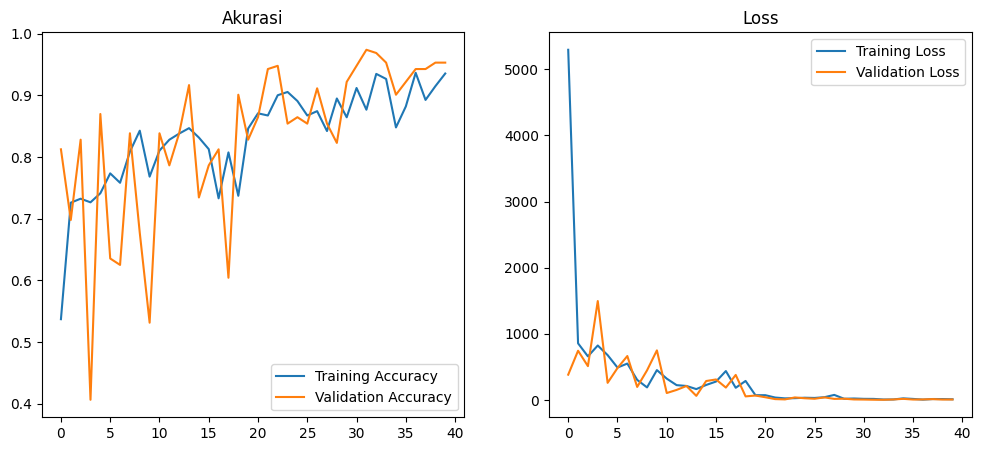

In [13]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Akurasi")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.legend()

plt.show()


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_image_cv2(model_ann, image_path, class_names, image_size=256):
    img = cv2.imread(image_path)  # baca gambar (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # konversi ke RGB
    img = cv2.resize(img, (image_size, image_size))  # resize
    img = img / 255.0  # normalisasi
    img_array = np.expand_dims(img, axis=0)  # batch dim
    
    prediction = model.predict(img_array)
    pred_index = np.argmax(prediction[0])
    confidence = prediction[0][pred_index] * 100
    
    plt.imshow(img)
    plt.title(f"Prediksi: {class_names[pred_index]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return class_names[pred_index], confidence


In [11]:
image_path = 'D:/Semester 6/AI/Artificial_Inteligence/new_images/Potato.jpg'
predicted_class, confidence = predict_image_cv2(model, image_path, class_name, Image_Size)
print(f"Prediksi kelas: {predicted_class} dengan confidence {confidence:.2f}%")

NameError: name 'model' is not defined